In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [4]:
# Just normalization for validation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [5]:
# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Load pre-trained VGG-16 model
model = torchvision.models.vgg16(pretrained=True)

C:\Users\dellG15\Documents\globalGpuEnvironmentForUse\myNewVenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dellG15\Documents\globalGpuEnvironmentForUse\myNewVenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Modify the classifier to fit CIFAR-100
model.classifier[6] = nn.Linear(4096, 100)

In [8]:
# Move the model to the GPU
model = model.to(device)

In [9]:
# Freeze all convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [11]:
# Training function
def train(model, criterion, optimizer, trainloader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [13]:
# Evaluation function
def evaluate(model, criterion, testloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(testloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [14]:
# Train and evaluate the model
num_epochs = 20
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, trainloader, device)
    val_loss, val_acc = evaluate(model, criterion, testloader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1/20, Train Loss: 3.4761, Train Acc: 0.1805, Val Loss: 2.7283, Val Acc: 0.3075
Epoch 2/20, Train Loss: 3.1131, Train Acc: 0.2356, Val Loss: 2.6309, Val Acc: 0.3231
Epoch 3/20, Train Loss: 3.0137, Train Acc: 0.2534, Val Loss: 2.5914, Val Acc: 0.3285
Epoch 4/20, Train Loss: 2.9519, Train Acc: 0.2638, Val Loss: 2.5134, Val Acc: 0.3444
Epoch 5/20, Train Loss: 2.9121, Train Acc: 0.2735, Val Loss: 2.4746, Val Acc: 0.3604
Epoch 6/20, Train Loss: 2.8762, Train Acc: 0.2760, Val Loss: 2.4915, Val Acc: 0.3532
Epoch 7/20, Train Loss: 2.8454, Train Acc: 0.2840, Val Loss: 2.4447, Val Acc: 0.3636
Epoch 8/20, Train Loss: 2.8360, Train Acc: 0.2856, Val Loss: 2.4359, Val Acc: 0.3643
Epoch 9/20, Train Loss: 2.8074, Train Acc: 0.2907, Val Loss: 2.4241, Val Acc: 0.3714
Epoch 10/20, Train Loss: 2.7897, Train Acc: 0.2952, Val Loss: 2.4278, Val Acc: 0.3702
Epoch 11/20, Train Loss: 2.7776, Train Acc: 0.2970, Val Loss: 2.4184, Val Acc: 0.3673
Epoch 12/20, Train Loss: 2.7752, Train Acc: 0.2982, Val Loss: 2

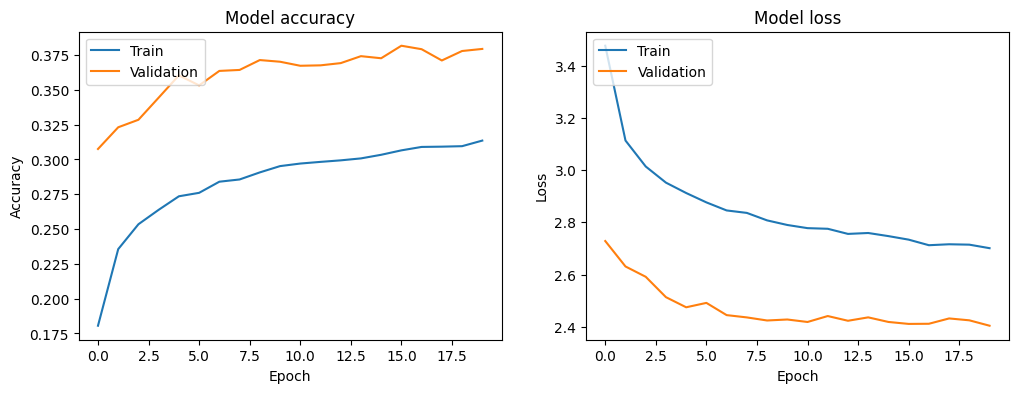

Test accuracy: 0.3794


In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model on the test data
test_loss, test_acc = evaluate(model, criterion, testloader, device)
print(f'Test accuracy: {test_acc}')



In [16]:
# Save the model
torch.save(model.state_dict(), 'vgg16_cifar100_finetuned_frozen.pth')